# Paper Description / Info

<br>

"We show how any dataset of any modality (time-series, images, sound...) can be approximated by a well-behaved (continuous, differentiable...) scalar function with a single real-valued parameter. Building upon elementary concepts from chaos theory, we adopt a pedagogical approach demonstrating how to adjust this parameter in order to achieve arbitrary precision fit to all samples of the data. Targeting an audience of data scientists with a taste for the curious and unusual, the results presented here expand on previous similar observations regarding expressiveness power and generalization of machine learning models."

Full info and details can be found here: https://arxiv.org/pdf/1904.12320.pdf

## Main Highlights

The paper shows that any data set can fit into a single numerical value using a simple logistic decoder function implemented and shown below:


In [107]:
# mpmath is a free BSD-licensed library for real and complex floating-point arithmetic with arbitrary precision.
from mpmath import sin, asin, sqrt

def two_to_the_power_of( num ):
    return 2 ** num

def squared( num ):
    return num ** 2

def logistic_decoder ( 
    # The real-valued number to be learned / generated from the data
    real_num
    # A series of integer values
    , x
    # The accuracy metric is a constant which controls our accuracy
    , accuracy_metric = 12
):
        
    return float(
        squared(
            sin( 
                two_to_the_power_of(x * accuracy_metric) * asin(sqrt(real_num))
            )
        )
    )


All the information produced by this algorithm will be directly encoded in a real-valued decimal number (called decimal_num above), without any compression or learning having to take place! 

The paper infers that since our information can be encoded into an real number which contains an infinite number of decimals, we can fit an infinite amount of information within it!! 

Before we dive into the full details and implementation of the algorithm, let's go over a few key building blocks which we'll need in order to fully understand how it works.

## Arithmetic Coding
  
Let's suppose we have a stream of the symbols: a, e, r, s and t.

Their probability is represented by this table:


|  Symbol      |  a        |  e        |  r        |  s        |   t        |
|  :----       |  :-----:  |  :-----:  |  :-----:  |  :-----:  |     ----:  |
|  Probability |  0.3      |  0.3      |  0.15     |  0.05     |   0.2      |

With this table in mind, we can build ranges containing all of the possible characters sorted by the most frequent to least, as illustrated below:

![arithmetic-coding-example-1](imgs/arithmetic-coding-example-1.jpg)

As an example, let's encode the string 'eat.' 

First, we pick the first symbol ('e') which is located within the sub-range of 0.3 to 0.6. 

We then take this sub-range and split it into segments using the same proportions we used before:

![arithmetic-coding-example-2](imgs/arithmetic-coding-example-2.jpg)

Next, we take the second symbol ('a') which will be located within the new sub-range (0.3 to 0.39). 

Finally, we take our last symbol t, and we repeat the same process again to get the last sub-range (0.354 to 0.372).

![arithmetic-coding-example-3](imgs/arithmetic-coding-example-3.jpg)

We just need to pick a number within the last subrange 0.354 to 0.372 and we're done! Let's choose 0.36. With this number, we'll be able to recover our original 'eat' stream!

If you think about it, it's like if we were drawing a line within ranges of ranges to encode our stream:

![arithmetic-coding-example-4](imgs/arithmetic-coding-example-4.jpg)

The reverse process of decoding is fairly easy as well. All we have to do it to take our encoded decimal (~0.36) and using our  original range checks, we should be able to re-construct our original string.

Full credit for the above explanation and images go to [Leandro Moreira](https://github.com/) and the full write up can be found using the link below:

https://github.com/leandromoreira/digital_video_introduction#arithmetic-coding


## Fixed point binary representation



Fixed point binary representation is very similar to the arithmetic coding concept we demoed above, except that instead of assigning characters to probability ranges, our numbers or characters are assigned to infinitely divisible binary real ranges. 

To put it more formally: each value is encoded into a set of binary coefficients (i.e. variables belonging to either 0 or 1), with each coefficient being paired to a weight of 1 / 2<sup>i</sup> for each coefficient a<sub>i</sub> as illustrated below:

<br>

<img src="imgs/binary-coefficient-illustration.jpg" alt="binary-coefficient-illustration" width="800"/>

<br>

Converting the above binary representation is accomplished by evaluating the infinite sum expression:

<img src="imgs/infinite-sum-expression-formula.jpg" alt="infinite-sum-expression" width="300"/>



In our arithmetic coding example, we assigned a specific range to each character within our alphabet. Here, we are doing things a bit differently. Instead of assigning our ranges according to the alphabet probability distribution, we simply divide up our space into equal length ranges. After deciding on how many ranges (and thus the precision) we want, we encode our binary value within this range. We proceed with continually halving our space again to encode the next value.

Using the above methodology, we still end up with a 'probability space' which equates to 1:

<img src="imgs/One-as-an-infinite-sum.jpg" alt="One as an infinite sum" width="400"/>

We do have one major issue though. In our original description, we assume that we can have infinite precision! 

Obviously, existing data solutions wouldn't allow us to divide our space into an infinite range of values. 

To account for this, our original function has an 'accuracy metric' variable which controls the number of ranges (and thus the precision) that we have to work with within each unit interval:

In [108]:
def logistic_decoder ( 
    real_num
    , x
    # The accuracy metric below controls the discretization of each unit interval. In the below example, 
    # we set thedefault to 8, which means that we will divide each sub-space into 8 uniform locations.
    , accuracy_metric = 8
):
    return float(sin(2 ** (x * accuracy_metric) * asin(sqrt(real_num))) ** 2)

The paper shows an example of using an accuracy metric of 8 and what that 8-bit expansion of an interval between 0 and 1 would look like:

<img src="imgs/eight-bit-precision-illustration.jpg" alt="eight-bit-precision-illustration"/>


Once again, we encode our data using a large enough accuracy metric (which divides each of our sub-spaces up into equally spaced intervals) and we continue on by halving each sub-space and continuing to encode the rest of our data within each half-space. We then add all of these results up to produce a decimal number between 0 and 1! 

This process is very similar to our original arithmetic coding example, albeit the methodology we use in encoding our information is a lot more mathematically beautiful!!

## Chaos Theory and Dyadic Transformations

Here, the paper goes on to describe a one-dimensional discrete dynamical system known as a "dyadic transformation." 

Given a variable located between (0, 1) at time step t, its evolution at time step t + 1 is defined by:


In [109]:
def two_to_the_power_of( num ):
    return 2 ** num

def mod_one( num ):
    return num % 1

def dyadic_decoder( real_num, time_step, accuracy_metric ):
    return mod_one(
        two_to_the_power_of( time_step * accuracy_metric ) * real_num
    )

The paper goes on and explains what the above transformation does by showing that the dynamic decoder in its binary form: the multiplication by 2 can be interpreted as a simple shift in the whole bit sequence of our real number parameter in the leftwise direction. 

Once again, our real_num parameter can be illustrated using the diagram below:

<img src="imgs/binary-coefficient-illustration.jpg" alt="binary-coefficient-illustration" width="800"/>

Multiplying by 2 shifts the bit sequence to the left by one, and the module operation ensures that every bit going over to the left-side of the radix point gets turned into a 0. We end up with the next set of encoded values to work with in our sequence. 

The whole operation is illustrated using the diagram below:

<br>

<img src="imgs/bit-shift-illustration.jpg" alt="bit-shift-illustration"/>


As a note, the paper also talks about why the above bit shifting transformations lead to chaotic dynamics: within each iteration, we lose the most significant bits of information, and we thus end up with a series of random bits which mostly depend on its least significant components! This is one of the key characteristics in many chaotic systems!

## Recap

Once again, the main idea is to:

1. Start by encoding all the data values '(x0, x1, x2, x3, ... xn)' into their binary representation truncated to the first r significant bits:

<br>

<img src="imgs/simple-recap-1.jpg" alt="simple-recap-1" width="800"/>

<br>

2. We then concatenate all of our data samples together to flatten the data set into a long binary string (composed of n * r bits):

<br>

<img src="imgs/simple-recap-2.jpg" alt="simple-recap-2"/>

<br>

Let's walk through some code which demonstrates the power of the algorithm described in the paper.

First, let's quickly show the methodology we're going to use in creating a random dataset composed of 100 data points:

In [122]:
import numpy as np

NUM_DATA_POINTS = 100
DATA = np.random.uniform(0, 1, NUM_DATA_POINTS)

print('DATA: ', str(DATA))


DATA:  [0.03142919 0.63641041 0.31435598 0.50857069 0.90756647 0.24929223
 0.41038292 0.75555114 0.22879817 0.07697991 0.28975145 0.16122129
 0.92969765 0.80812038 0.63340376 0.87146059 0.80367208 0.18657006
 0.892559   0.53934224 0.80744016 0.8960913  0.31800347 0.11005192
 0.22793516 0.42710779 0.81801477 0.86073058 0.00695213 0.5107473
 0.417411   0.22210781 0.11986537 0.33761517 0.9429097  0.32320293
 0.51879062 0.70301896 0.3636296  0.97178208 0.96244729 0.2517823
 0.49724851 0.30087831 0.28484049 0.03688695 0.60956433 0.50267902
 0.05147875 0.27864646 0.90826589 0.23956189 0.14489487 0.48945276
 0.98565045 0.24205527 0.67213555 0.76161962 0.23763754 0.72821635
 0.36778313 0.63230583 0.63352971 0.53577468 0.09028977 0.8353025
 0.32078006 0.18651851 0.04077514 0.59089294 0.67756436 0.01658783
 0.51209306 0.22649578 0.64517279 0.17436643 0.69093774 0.38673535
 0.93672999 0.13752094 0.34106635 0.11347352 0.92469362 0.87733935
 0.25794163 0.65998405 0.8172222  0.55520081 0.52965058 0.

Next, we show the rest of our code demoing both the encoding and decoding functionality:

In [111]:
from functools import reduce
from mpmath import mp, power
import numpy as np

PRECISION = 10

# Seed value:
SEED = 42
np.random.seed( SEED )

def print_separator( num_dashes = 120):
    print( '-' * num_dashes )

# First, lets create a dataset composed of random data points:
NUM_DATA_POINTS = 100
DATA = np.random.uniform(0, 1, NUM_DATA_POINTS)

# Mpmath uses a global working precision, so we calculate the required precision we need to work with
# and set it to an appropriate value:
MP_PRECISION = NUM_DATA_POINTS * PRECISION
mp.prec = MP_PRECISION

print("DATA: ", str(DATA))
print_separator()

# Functions which we're going to use to encode and decode our data:

def mod_one( num ):
    return num % 1

def dyadic_map( x ):
    return mod_one(2 * x)

def two_to_the_power_of(num):
    return power(2, num)

def decimal_to_binary( real_num, precision = PRECISION):

    def convert_to_binary_string(num):
        return '0' if num < 0.5 else '1'

    # The reduce function iterates over all elements of a list/array and returns one value which is composed
    # of an accumulated result of an operation performed through a passed in lambda function:
    return reduce(
        # The function to use to reduce our data set. The accumulator represents our aggregated result, while
        # x represents the next element to process within our sequence:
        lambda accumulator, next_element: [
            dyadic_map( accumulator[0] ), accumulator[1] + convert_to_binary_string(accumulator[0])
        ]
        # The sequence of values to perform our reduce operation on
        , range( precision )
        # If an initial value is present, it is placed before the items of the sequence in the calculation, and serves
        # as a default when the sequence is empty. Here, we start off with a 2 element array, with the first
        # element representing our decimal number, and the 2nd element which holds our binary representation:
        , [real_num, '']
    ) [1] # Note that we return the 2nd element in our reduction, which holds our binary representation!

def binary_to_decimal( binary_num ):

    return reduce (
        # Reduce function:
        lambda accumulator, next_element:
            accumulator + int(next_element[1]) / two_to_the_power_of(next_element[0] + 1)
        
        # Sequence: Iterate over the binary digits / representation
        , enumerate( binary_num )
        
        # Initial: We initialize it to a real/floating point value of 0.0
        , mp.mpf(0.0)
    )

# Finally, we can demo the encoding and decoding process and show the results:

binary_representation = ''.join(map( decimal_to_binary, DATA ))

print( 'BINARY REPRESENTATION: ' , str(binary_representation) )
print_separator()

decimal = binary_to_decimal( binary_representation )

print( 'DECIMAL REPRESENTATION: ', str(decimal))
print_separator()

def dyadic_decoder( real_num, time_step, precision = PRECISION ):
    return mod_one(
        two_to_the_power_of( time_step * precision ) * real_num
    )

decoded_values = [
    float( dyadic_decoder( real_num = decimal, time_step = time_idx ))
    for time_idx
    in range(NUM_DATA_POINTS)
]

print( "DECODED VALUES: ", str( np.array( decoded_values ) ) )


DATA:  [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249 0.12203823 0.49517691
 0.03438852 0.9093204  0.25877998 0.66252228 0.31171108 0.52006802
 0.54671028 0.18485446 0.96958463 0.77513282 0.93949894 0.89482735
 0.59789998 0.92187424 0.0884925  0.19598286 0.04522729 0.32533033
 0.38867729 0.27134903 0.82873751 0.35675333 0.28093451 0.54269608
 0.14092422 0.80219698 0.07455064 0.98688694 0.77224477 0.19871568
 0.00552212 0.81546143 0.70685734 0.72900717 0.77127035 0.07404465
 0.35846573 0.11586906 0.86310343 0.62329813 0.33089802 0.06355835
 0.31098232 0.32518332 0.72960618 0.63755747 0.88721274

## Applying makeup to the scaffolding

The paper refers to the above methodology of encoding and decoding information as 'bulding the scaffolding' for a reason: it feels like the decoding function leaves too much of the bare mechanics exposed! The paper also explains that the modulo arithmetic and bit shifting aren't a very elegant way of doing things. 

The purpose of the next section is to justify the more aesthetically pleasing formuation of our logistic function. The full function is shown once again below:

In [112]:
from mpmath import sin, asin, sqrt

def two_to_the_power_of( num ):
    return 2 ** num

def squared( num ):
    return num ** 2

def logistic_decoder ( 
    real_num
    , x
    , precision = 8
):
    return float( 
        squared( 
            sin( 
                two_to_the_power_of( x * precision ) * asin( sqrt( real_num ) )
            )
        ) 
    )

To apply the new 'makeup' to our original transformations, we need to introduce two well-known concepts in the context of dynamical systems: 

1. The logistic map. 
2. The notion of topological conjugacy. 

## The Logistic Map

This logistic map model is based on the common s-curve logistic function that shows how a population grows slowly, then rapidly, before tapering off as it reaches its carrying capacity. It’s called the logistic map because it maps the population value at any time step using the value from the previous step.

In [113]:
def logistic_equation(x, growth_factor):
    return growth_factor * x * ( 1 - x )

This equation defines the full rules and dynamics of our system: x represents the population at any given time t. It expresses the fact that the population level at any given time is a function of the growth rate parameter and the previous time step’s population level. If the growth rate is set to a low value, the population will die out and go extinct. Higher growth rates might settle toward a stable value or fluctuate across a series of population booms and busts.

Graphically represented, this equation depicts a concave down parabola:

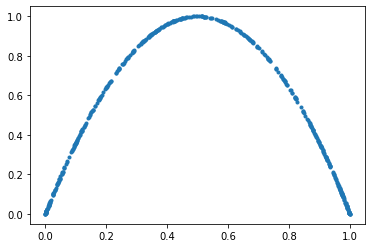

In [114]:
import pylab
import numpy

def logistic_equation(x, growth_factor):
    return growth_factor * x * ( 1 - x )

GROWTH_RATE = 4
coordinate_points = []
x = 0.1

# Do this 500 times
for _ in range(500):
    y = logistic_equation(x, GROWTH_RATE)
    # Add the point (x, y) to our list of coordinates to graph
    coordinate_points.append( [x, y] )
    # We feed in our output value into our next input and repeat the same process
    x = y

# Convert the coordinate point list of lists into a 2D numpy array.
coordinate_points = numpy.array(coordinate_points)

# This draws a scatter plot of the (x, y) values
def draw_scatterplot( coordinate_points ):
    pylab.plot(coordinate_points[:,0], coordinate_points[:,1], '.')
    pylab.show()

draw_scatterplot( coordinate_points )

So - what do logistic maps have to do with anything we discussed so far?

## Topological Conjugacy

Let's assume that we have input / data element from a sequence of values produced by the logistic map which can be linked to some real number variable:


In [115]:
from mpmath import sin, pi

def squared( num ):
    return num ** 2

def phi( real_num ):
    return squared( 
        sin( 2 * pi * real_num ) 
    )

We need to find a real_num parameter as an iteration of the dyadic transformation which we defined earlier (and which is once again provided below):

In [116]:
def mod_one( num ):
    return num % 1

def dyadic_map( x ):
    return mod_one(2 * x)

For now, we'll continue to follow the evolution of our input data as perscribed by our logistic map. 

Using the newly introduced phi function, the value of the next iteration can be expressed as:

In [117]:
from mpmath import sin, pi, almosteq
from random import random
mp.prec = 8

def squared( num ):
    return num ** 2

def phi( real_num ):
    return squared( sin( 2 * pi * real_num ) )

CURRENT_ITER = random()
next_iterate = 4 * phi(CURRENT_ITER) * (1 - phi(CURRENT_ITER))

# The above can be simplified to:
next_iterate_simple = phi( 2 * CURRENT_ITER )

# Let's do an assertion to show that our simplification equates to our earlier logistic iterate
assert almosteq( next_iterate, next_iterate_simple )

Let's plot the above to show that our above map has a periodicity:

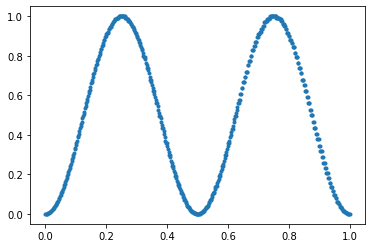

In [118]:
import pylab
import numpy as np
from mpmath import sin, pi

NUM_POINTS = 500

def squared( num ):
    return num ** 2

def phi( x ):
    return float( squared( sin( 2 * pi * x ) ) )

coordinate_points = []
x_values = np.linspace(0, 1, NUM_POINTS)

for x in x_values:
    y = phi( x )
    coordinate_points.append( [x, y] )
    
coordinate_points = np.array(coordinate_points)

def draw_scatterplot( coordinate_points ):
    pylab.plot(coordinate_points[:,0], coordinate_points[:,1], '.')
    pylab.show()

draw_scatterplot( coordinate_points )

Due to the above periodicity of the phi function, we can extract the below assertion / identity:

In [119]:
from mpmath import sin, pi, almosteq, mp
from random import random

PRECISION = 8
mp.prec = PRECISION

def squared( num ):
    return num ** 2

def mod_one( num ):
    return num % 1

def phi( real_num ):
    return squared( sin( 2 * pi * real_num ) )

def dyadic_map( x ):
    return mod_one(2 * x)

CURRENT_ITER = random()
next_phi_iterate = phi( 2 * CURRENT_ITER )
next_dyadic_iterate = dyadic_map( CURRENT_ITER )

# Also, knowing that next_dyadic_map_iterate = dyadic_map( previous_iterate ), we can infer that:
assert almosteq( next_phi_iterate, phi( next_dyadic_iterate) )

print( 'NEXT PHI ITERATE: ', str( next_phi_iterate ))
print( 'PHI OF NEXT DYADIC ITERATE: ', str( phi( next_dyadic_iterate) ) )


NEXT PHI ITERATE:  0.5
PHI OF NEXT DYADIC ITERATE:  0.5


The above result is extraordinary!! 

It proves that although our logistic and combined phi and dyaduc map functions look like different recurrence relations, they're actually topological 'twins' that share identical dynamics!!

With phi and inverse_phi acting as bridges between the two toplogical spaces, this behavior is known as topological conjugacy and can be summarized pictorally via the diagram below:

<br>

<img src="imgs/topological-conjugation-illustration.jpg" alt="topological-conjugation-illustration" width="800"/>

In other words, one may decide to study the dynamics of a variable according to the logistic map and never leave
this representation but, all the while, think about how these dynamics are equivalently represented in some kind of
“parallel universe” where variables evolve according to the dyadic transformation up to a compositional “portal”
in the form of phi.

We're now going to exploit the above cojugacy to the encoding/decoding strategy we outlined in our previous sections and we're going to demo a new way of generating a parameter which represents our entire data set!

## Construction of the initial condition

If you can recollect, in our previous examples, we approximated our data points using binary approximations as the first step in our algorithm. This time, we start with a pre-processing step of applying inverse-phi to all of the sample data prior to doing the conversion to our binary-representation, as illustrated below:

<img src="imgs/phi-binary-fixed-point-encoding-illustration.jpg" alt="phi-binary-fixed-point-encoding-illustration" width="900" />

After the above step is performed, the results are concentated together into a long real-valued parameter which encodes our information by halving the state space during each iteration:

<br>

<img src="imgs/phi-concatenation-illustration.jpg" alt="phi-concatenation-illustration"/>

Having built our real number in the conjugate space, we can use our topological conjugacy to transport the initial condition back to the origina data domain by using our phi function as a 'portal' or bridge between the 2 spaces. 

## Decoding using the logistic map

The paper walks us through a derivation of a logistic decoding function, which is once again provided below:

In [120]:
from mpmath import sin, asin, sqrt

def two_to_the_power_of( num ):
    return 2 ** num

def squared( num ):
    return num ** 2

def logistic_decoder ( 
    real_num
    , x
    , precision = 8
):
    return float( 
        squared( 
            sin( 
                two_to_the_power_of( x * precision ) * asin( sqrt( real_num ) )
            )
        ) 
    )

The paper walks through the exact details in why the above conjugation and mapping work. We exclude this from our discussion, since the aim of this write-up is to briefly demo and provide a higher-level overview of the algorithm. 

Next, let's walk through another full example where we use the methodologies outlined in the previous sections to show that we can map any arbitrary amount of data to a single real-valued parameter:

In [121]:
from functools import reduce
from mpmath import mp, power, sin, pi, asin, sqrt
import numpy as np

PRECISION = 10

# Seed value:
SEED = 42
np.random.seed(SEED)

def print_separator(num_dashes=120):
    print('-' * num_dashes)

# First, let's create a dataset composed of random data points:
NUM_DATA_POINTS = 100
DATA = np.random.uniform(0, 1, NUM_DATA_POINTS)

# Mpmath uses a global working precision. We calculate the global precision value we need and set it accordingly.
MP_PRECISION = NUM_DATA_POINTS * PRECISION
mp.prec = MP_PRECISION

print("DATA: ", str(DATA))
print_separator()

# Functions which we're going to use to encode and decode our data:

def squared( num ):
    return num ** 2

def phi( real_num ):
    return squared( sin( 2 * pi * real_num ) )

def inverse_phi( real_num ):
    return asin( sqrt( real_num )) / (2 * np.pi)

def mod_one( num ):
    return num % 1

def dyadic_map( x ):
    return mod_one(2 * x)

def two_to_the_power_of(num):
    return power(2, num)

def decimal_to_binary( real_num, precision = PRECISION):

    def convert_to_binary_string(num):
        return '0' if num < 0.5 else '1'

    return reduce(
        # The function to use to reduce our data set. The accumulator represents our aggregated result, while
        # x represents the next element to process within our sequence:
        lambda accumulator, next_element: [
            dyadic_map( accumulator[0] ), accumulator[1] + convert_to_binary_string(accumulator[0])
        ]
        # The sequence of values to perform our reduce operation on
        , range( precision )
        # If an initial value is present, it is placed before the items of the sequence in the calculation, and serves
        # as a default when the sequence is empty. Here, we start off with a 2 element array, with the first
        # element representing our decimal number, and the 2nd element which holds our binary representation:
        , [real_num, '']
    ) [1] # Note that we return the 2nd element in our reduction, which holds our binary representation!

def binary_to_decimal( binary_num ):

    return reduce (
        # Function
        lambda accumulator, next_element:
            accumulator + int(next_element[1]) / two_to_the_power_of(next_element[0] + 1)
        # Sequence: Iterate over the binary digits / representation
        , enumerate( binary_num )
        # Initial: We initialize it to a real/floating point value of 0.0
        , mp.mpf(0.0)
    )

def binary_conjugate( data ):
    decimal_to_binary_phi_inverse = lambda z : decimal_to_binary( inverse_phi( z ), PRECISION )
    return ''.join( map( decimal_to_binary_phi_inverse, data) )

# Finally, we can demo the encoding and decoding process and show the results:

binary_conjugate_str = binary_conjugate( DATA )

print( 'BINARY CONJUGATE: ' , binary_conjugate_str )
print_separator()

decimal_conjugate = binary_to_decimal( binary_conjugate_str )

print( 'DECIMAL CONJUGATE: ' , decimal_conjugate )
print_separator()

decimal = phi( decimal_conjugate )

print( 'DECIMAL: ' , str(decimal) )
print_separator()

def logistic_decoder (
    real_num
    , time_step
    , precision = PRECISION
):
    return float(
        squared(
            sin(
                two_to_the_power_of( time_step * precision ) * asin( sqrt( real_num ) )
            )
        )
    )

decoded_values = [
    float( logistic_decoder( real_num = decimal, time_step = time_idx) )
    for time_idx
    in range(NUM_DATA_POINTS)
]

print( "DECODED VALUES: ", str( np.array( decoded_values ) ) )


DATA:  [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596 0.19967378 0.51423444 0.59241457 0.04645041
 0.60754485 0.17052412 0.06505159 0.94888554 0.96563203 0.80839735
 0.30461377 0.09767211 0.68423303 0.44015249 0.12203823 0.49517691
 0.03438852 0.9093204  0.25877998 0.66252228 0.31171108 0.52006802
 0.54671028 0.18485446 0.96958463 0.77513282 0.93949894 0.89482735
 0.59789998 0.92187424 0.0884925  0.19598286 0.04522729 0.32533033
 0.38867729 0.27134903 0.82873751 0.35675333 0.28093451 0.54269608
 0.14092422 0.80219698 0.07455064 0.98688694 0.77224477 0.19871568
 0.00552212 0.81546143 0.70685734 0.72900717 0.77127035 0.07404465
 0.35846573 0.11586906 0.86310343 0.62329813 0.33089802 0.06355835
 0.31098232 0.32518332 0.72960618 0.63755747 0.88721274

## Data science perspective: what about generalization?

So, what does this mean in terms of machine learning?

The paper goes on the explain that the real number we construct from our data isn't really 'learned' per say. The above algorithm simply builds a decimal value through a very neat encoding mechanism and thus does not generalize. In other words, our methodology above simply creates a compact representation of our training data!

Still, the paper does present a great way of compactly 'compressing' data in a mathematically beautiful way, so kudos to the author and his collaborators on bringing these algorithms and encoding/decoding techniques to light!

Full credit for the images and algorithm info go to the original author of the paper 'Real numbers, data science and chaos: How to fit any dataset with a single parameter.' [Laurent Boue](https://github.com/Ranlot)

A lot more info can be found in the original paper, as well as the Github repository which contains many more examples and code, so I urge any interested readers to explore further! 

The info used in compiling the above paper summary are provided below:

Great link explaining arithmetic coding:

- [Arithmetic Coding Explained](https://github.com/leandromoreira/digital_video_introduction#arithmetic-coding)

Paper code and info:

- [Arxiv Link](https://arxiv.org/abs/1904.12320)
- [PDF Link](https://arxiv.org/pdf/1904.12320.pdf)
- [Github Repo](https://github.com/Ranlot/single-parameter-fit)
